# L2-B - Linear Quantization I: Get the Scale and Zero Point

In this lesson, continue to learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Linear Quantization I` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch

from helper import linear_q_with_scale_and_zero_point, linear_dequantization, plot_quantization_errors

### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

## Finding `Scale` and `Zero Point` for Quantization

In [2]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max

In [3]:
q_min

-128

In [4]:
q_max

127

In [5]:
# r_min = test_tensor.min()
r_min = test_tensor.min().item()

In [6]:
r_min

-184.0

In [7]:
r_max = test_tensor.max().item()

In [8]:
r_max

728.5999755859375

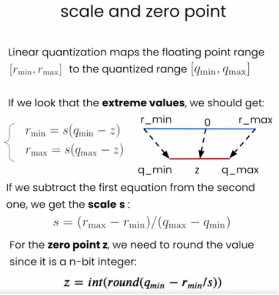

In [ ]:
# scale计算公式
scale = (r_max - r_min) / (q_max - q_min)

In [10]:
scale

3.578823433670343

In [ ]:
# zero_point计算公式
zero_point = q_min - (r_min / scale)

In [12]:
zero_point

-76.58645490333825

In [ ]:
# zero_point需要四舍五入并取整
zero_point = int(round(zero_point))

In [14]:
zero_point

-77

- Now, put all of this in a function.

In [ ]:
# 针对原始tensor和要量化的数据类型，计算对应的scale和zero_point
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [16]:
new_scale, new_zero_point = get_q_scale_and_zero_point(
    test_tensor)

In [17]:
new_scale

3.578823433670343

In [18]:
new_zero_point

-77

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [ ]:
# 使用计算出的new_scale和new_zero_point对test_tensor进行量化
quantized_tensor = linear_q_with_scale_and_zero_point(
    test_tensor, new_scale, new_zero_point)

In [ ]:
# 使用计算出的new_scale和new_zero_point对quantized_tensor进行反量化
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           new_scale, new_zero_point)

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

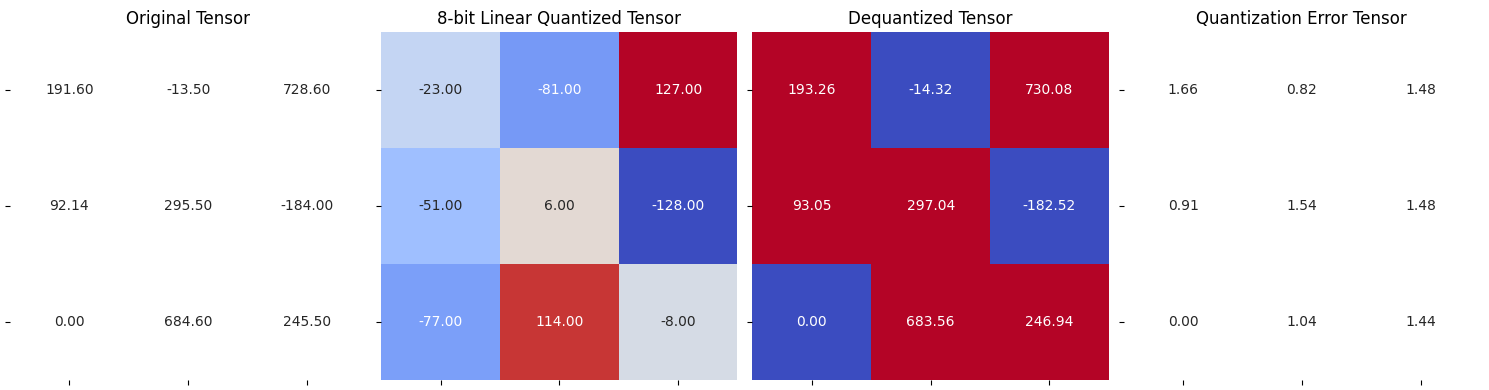

In [ ]:
# 图形化显示量化误差
plot_quantization_errors(test_tensor, quantized_tensor, 
                         dequantized_tensor)

In [ ]:
# 计算总体量化误差
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [ ]:
# 线性量化器，将原始tensor量化为dtype类
def linear_quantization(tensor, dtype=torch.int8):
    # 计算scale和zero_point
    scale, zero_point = get_q_scale_and_zero_point(tensor, 
                                                   dtype=dtype)
    
    # 使用计算出的scale和zero_point对tensor进行量化
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor,
                                                          scale, 
                                                          zero_point, 
                                                          dtype=dtype)
    
    # 返回量化后的quantized_tensor，scale和zero_point
    return quantized_tensor, scale , zero_point

- Test your implementation on a random matrix.

In [24]:
r_tensor = torch.randn((4, 4))

**Note:** Since the values are random, what you see in the video might be different than what you will get.

In [25]:
r_tensor

tensor([[ 0.4485,  1.3725,  0.4656,  0.3944],
        [-1.4159,  1.3243, -1.6501,  0.2169],
        [-0.7188, -0.4212, -1.4186,  0.1431],
        [ 0.2211, -2.2244, -0.7172, -1.1446]])

In [ ]:
# 执行量化
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [27]:
quantized_tensor

tensor([[  62,  127,   63,   58],
        [ -70,  124,  -87,   45],
        [ -21,    0,  -71,   40],
        [  46, -128,  -21,  -51]], dtype=torch.int8)

In [28]:
scale

0.014105439653583601

In [29]:
zero_point

30

In [ ]:
# 执行反量化
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           scale, zero_point)

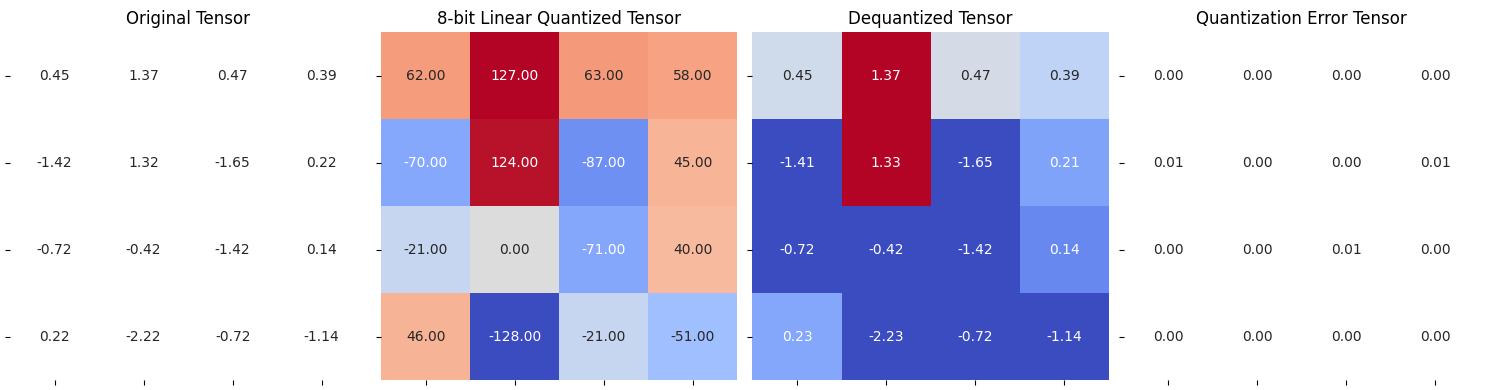

In [31]:
plot_quantization_errors(r_tensor, quantized_tensor,
                         dequantized_tensor)

In [ ]:
# 量化总体均方误差非常小
(dequantized_tensor-r_tensor).square().mean()

tensor(1.1154e-05)